In [139]:
# Import dependencies
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

DEVIDE = "cuda" if torch.cuda.is_available() else "cpu"

In [128]:
# Get data
transform = transforms.ToTensor()

mnist_data = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
data_loader = DataLoader(mnist_data, batch_size=64, shuffle=True)

In [129]:
# Analyze data

dataiter = iter(data_loader)
images, labels = next(dataiter)
print(torch.min(images), torch.max(images))

tensor(0.) tensor(1.)


In [130]:
# Define a linear AutoEncoder 
class AutoEncoder(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        # N (batch size), 784 (28x28)
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128), # N, 784 -> N, 128
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 2), # N, 2
        )

        self.decoder = nn.Sequential(
            nn.Linear(2, 12), 
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28), # N, 784
            nn.Sigmoid() # IMPORTTANT! Depending on data we might need different activation here!
        )
# NOTE: Last activation: [0, 1] -> nn.ReLU(), [-1, 1] -> nn.Tanh

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    


In [131]:
# Instantiate neural net and loss
autoencoder = AutoEncoder()
criterion = nn.MSELoss()

# Config training
num_epochs = 10
optimizer = optim.Adam(autoencoder.parameters(), lr=5e-4, weight_decay=1e-5)

In [132]:
# Train the Autoencoder
def train(autoencoder, optimizer, criterion, data_loader, num_epochs=10):
    outputs = []
    
    for epoch in range(num_epochs):
        for img, _ in data_loader:
            img = img.reshape(-1, 28*28)
            recon = autoencoder(img)
            loss = criterion(recon, img)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch:{epoch+1}, Loss:{loss.item():.4f}")
        outputs.append((epoch, img, recon))
    return outputs, autoencoder

In [133]:
outputs, autoencoder = train(autoencoder, optimizer, criterion, data_loader, num_epochs)

Epoch:1, Loss:0.0487
Epoch:2, Loss:0.0476
Epoch:3, Loss:0.0490
Epoch:4, Loss:0.0516
Epoch:5, Loss:0.0492
Epoch:6, Loss:0.0510
Epoch:7, Loss:0.0457
Epoch:8, Loss:0.0476
Epoch:9, Loss:0.0502
Epoch:10, Loss:0.0450


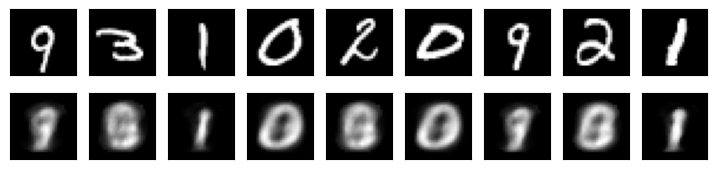

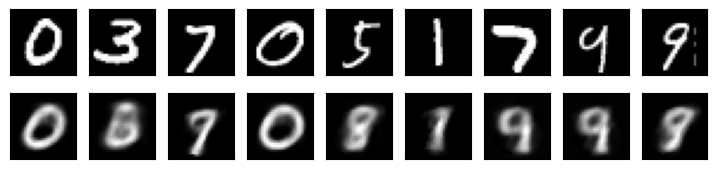

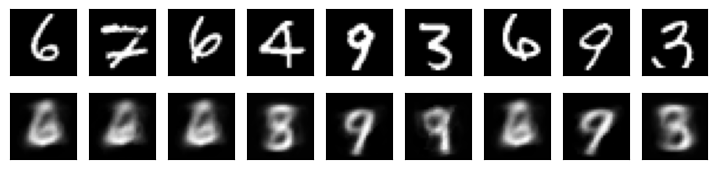

In [134]:
# Plot the reconstructed images
for k in range(0, num_epochs, 4):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()

    for i, item in enumerate(imgs):
        if i >= 9: break

        plt.subplot(2, 9, i+1)
        plt.tick_params(left = False, 
                        right = False,
                        labelleft = False,
                        labelbottom = False,
                        bottom = False
                        )
        item = item.reshape(-1, 28, 28)
        plt.imshow(item[0])

    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1)
        plt.tick_params(left = False, 
                        right = False,
                        labelleft = False,
                        labelbottom = False,
                        bottom = False
                        )
        item = item.reshape(-1, 28, 28)
        plt.imshow(item[0])

In [135]:
def plot_latent(autoencoder, data_loader, num_batches=100):
    for i, (img, label) in enumerate(data_loader):
        img = img.reshape(-1, 28*28)
        z = autoencoder.encoder(img).to(DEVICE)
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=label, cmap='tab10', marker=".")
        if i > num_batches:
            plt.colorbar()
            break

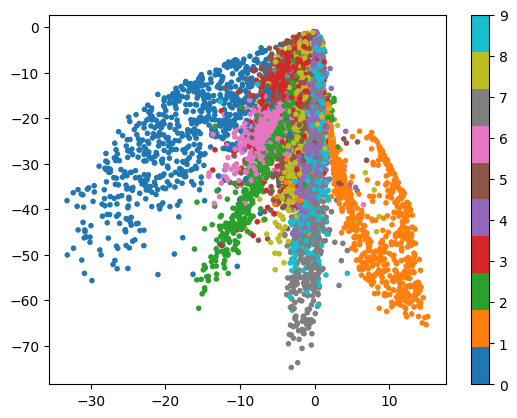

In [136]:
plot_latent(autoencoder, data_loader)

In [137]:
import numpy as np
def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12):
    width = 28
    img = np.zeros((n*width, n*width))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(DEVICE)
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to(DEVICE).detach().numpy()
            img[(n-1-i)*width:(n-1-i+1)*width, j*width:(j+1)*width] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

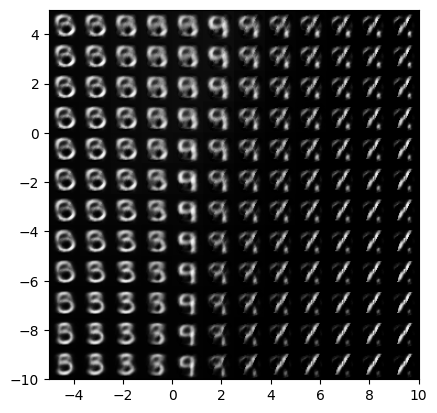

In [138]:
plot_reconstructed(autoencoder)